## N5K challenge in python

In [1]:
%%time
from classy_sz import Class as Class_sz



precision_params = {
'N_samp_fftw' : 512 ,
'k_min_n5k' : 1e-4,
'k_max_n5k' : 1e1,
'chi_min_n5k_samp_fftw' : 7e-2,
'chi_max_n5k_samp_fftw' : 7e3,
}



# dummy set-up to initialize class_sz
classy_sz = Class_sz()
classy_sz.set(precision_params)
classy_sz.set({
'output': 'tSZ_tSZ_1h',
'ndim_redshifts' :10,
'use_fft_for_profiles_transform' : 1, 
})
classy_sz.compute_class_szfast()

CPU times: user 5.6 s, sys: 2.77 s, total: 8.37 s
Wall time: 5.88 s


In [2]:
classy_sz.load_n5k_cl_K1()
classy_sz.load_n5k_pk_zk()
classy_sz.load_n5k_z_of_chi()

1

In [3]:
%%time
import numpy as np
import mcfit
from scipy.integrate import quad
import pathos.multiprocessing as mp

# Initialize parameters
lnk_min_n5k = np.log(precision_params['k_min_n5k'])
lnk_max_n5k = 2.*np.log(precision_params['k_max_n5k'])
chimin = precision_params['chi_min_n5k_samp_fftw']
chimax = 2*precision_params['chi_max_n5k_samp_fftw']
N_samp_fftw = precision_params['N_samp_fftw']
chiarr = np.geomspace(chimin, chimax, N_samp_fftw)

zchi = np.vectorize(classy_sz.get_n5k_z_of_chi)(chiarr)
K = np.vectorize(classy_sz.get_n5k_cl_K1_at_chi)(chiarr)

clgg = np.load('/Users/boris/Work/CLASS-SZ/SO-SZ/N5K/tests/benchmarks_nl_clgg.npz')


def get_cl_nonlimber(l):
    def integrand_k(lnk):
        k = np.exp(lnk)
        
        pk = np.vectorize(classy_sz.get_n5k_pk_at_z_and_k)(zchi, k)        
        Pchi = np.sqrt(pk) * K

        chit = np.zeros_like(chiarr)
        Pchit = np.zeros_like(chiarr)
        
        if fft_method == 'class_sz':
            classy_sz.get_fftlog_ComputeXiLMsloz(l, 0, N_samp_fftw, chiarr, Pchi, chit, Pchit)
            F1 = 2. * np.pi**2 * np.interp(k, chit, Pchit, left=0, right=0) * k

        
        if fft_method == 'mcfit_hankel':
            H = mcfit.transforms.Hankel(chiarr, nu=l+0.5, q=1, N=N_samp_fftw,lowring=True) # default q = 1
            Fmcfit = Pchi/chiarr*np.sqrt(np.pi/2./chiarr/k) # for hankel
            chit, Pchit = H(Fmcfit, extrap=True)
            F1 = np.interp(k, chit, Pchit, left=0, right=0) * k

            
        if fft_method == 'mcfit_bessel':
            H = mcfit.transforms.SphericalBessel(chiarr, nu=l, q=1.5, N=N_samp_fftw,lowring=True) # default q = 1.5
            Fmcfit = Pchi/chiarr**2 * np.sqrt(np.pi/2.)# for bessel
            chit, Pchit = H(Fmcfit, extrap=True)
            F1 = np.interp(k, chit, Pchit, left=0, right=0) * k 
            
        intk = k * F1**2
        return intk

    result, error = quad(integrand_k, lnk_min_n5k, lnk_max_n5k, epsabs=1e-6, epsrel=1e-4)
    cl = result * 2. / np.pi
    return cl

def parallel_get_cls(ls):
    with mp.Pool(mp.cpu_count()) as pool:
        cls = pool.map(get_cl_nonlimber, ls)
    return cls

# Convert ls to integers
ls = [int(l) for l in clgg['ls']]




CPU times: user 7.57 ms, sys: 5.86 ms, total: 13.4 ms
Wall time: 20.4 ms


In [4]:
%%time
fft_method = 'class_sz'
cls_class_sz = np.asarray(parallel_get_cls(ls))

CPU times: user 23.8 ms, sys: 52.8 ms, total: 76.5 ms
Wall time: 529 ms


In [5]:
%%time
fft_method = 'mcfit_hankel'
cls_mcfit_hankel = np.asarray(parallel_get_cls(ls))

CPU times: user 18.6 ms, sys: 35 ms, total: 53.5 ms
Wall time: 610 ms


In [6]:
%%time
fft_method = 'mcfit_bessel'
cls_mcfit_bessel = np.asarray(parallel_get_cls(ls))

CPU times: user 20.2 ms, sys: 31.2 ms, total: 51.4 ms
Wall time: 744 ms


/var/folders/h0/4_tf3pcn1h32ks9grh325v400000gn/T/ipykernel_20952/4129545169.py:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,2200)


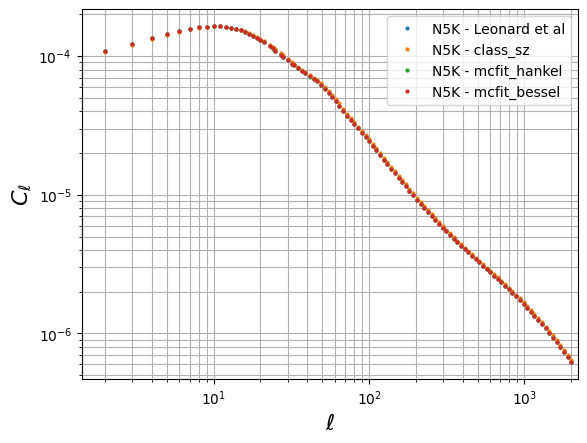

In [7]:

import matplotlib.pyplot as plt
plt.plot(clgg['ls'],clgg['cls'][0],marker='o',markersize=2.,label='N5K - Leonard et al',ls='None')
plt.plot(clgg['ls'],cls_class_sz,marker='o',markersize=2.,label='N5K - class_sz',ls='None')
plt.plot(clgg['ls'],cls_mcfit_hankel,marker='o',markersize=2.,label='N5K - mcfit_hankel',ls='None')
plt.plot(clgg['ls'],cls_mcfit_bessel,marker='o',markersize=2.,label='N5K - mcfit_bessel',ls='None')

plt.xscale('log')
plt.yscale('log')
plt.xlim(0,2200)
plt.legend()
plt.xlabel(r'$\ell$',size=16)
plt.ylabel(r'$C_\ell$',size=16)
plt.grid(which='both')

Text(0, 0.5, 'ratio')

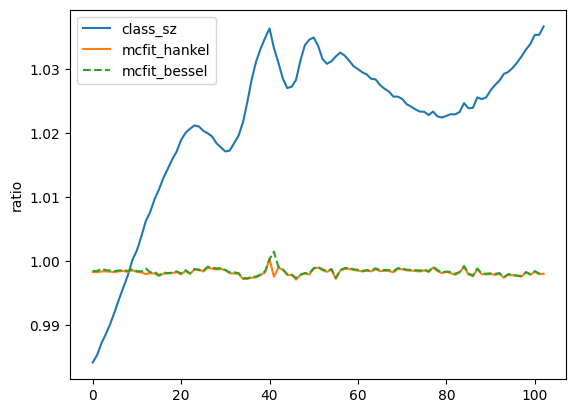

In [8]:
plt.plot(cls_class_sz/clgg['cls'][0],label='class_sz')
plt.plot(cls_mcfit_hankel/clgg['cls'][0],label='mcfit_hankel')
plt.plot(cls_mcfit_bessel/clgg['cls'][0],label='mcfit_bessel',ls='--')
plt.legend()
plt.ylabel('ratio')

Text(0, 0.5, 'relative diff in percents')

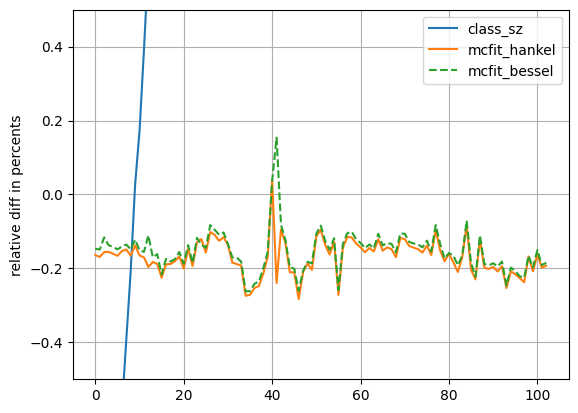

In [9]:
plt.plot(100.*(cls_class_sz/clgg['cls'][0]-1.),label='class_sz')
plt.plot(100.*(cls_mcfit_hankel/clgg['cls'][0]-1.),label='mcfit_hankel')
plt.plot(100.*(cls_mcfit_bessel/clgg['cls'][0]-1.),label='mcfit_bessel',ls='--')
plt.legend()
plt.grid(which='both')
plt.ylim(-0.5,0.5)
plt.ylabel('relative diff in percents')